# Cluster analysis

This notebook serves to visualize clusters extracted from the sales data.
Clustering can be done by any of the following methods:
* Dimentionality reduction followed by clustering using HDBCAN
* Self-Organizing Maps
* Dynamic Time Wapring Distance calculation followed by agglomerative clustering

Each of these techniques can have their clusters analysed in this notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
import umap
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from VisualizationFunctions import plot_by_factor, AnalyzeClusters
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from dynamic_time_warping import Preprocessing
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline

Read in the data: labels, tsfresh features, product level aggregate time series, pivot table.

Scale the data.

In [6]:
df = pd.read_csv('../data/processed/shoe_extracted_features.csv')
product_sales = pd.read_csv('../data/raw/quantity+by+sku+and+tran_date.csv')
df.dropna(axis=1, inplace=True)

scale = StandardScaler()
skus = df['id']
df.set_index('id', inplace=True)
X = scale.fit_transform(df)
names = df.columns

In [7]:
product_sales.drop('Unnamed: 0', axis=1, inplace=True)
product_sales.columns = ['sku_key', 'tran_date', 'sales']

# Dimentionality reduction
---
This dimentionality reduction is first of all for visualization of clusters, and also to see if any other groupings emerge from the dataset

In [85]:
print('Running UMAP Dimentionality Reduction...')
um = umap.UMAP(n_neighbors=15, min_dist=0.3)
umaps = um.fit_transform(X)

Running UMAP Dimentionality Reduction...


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/umap_learn-0.3.6-py3.6.egg/umap/spectral.py:229: UserWarning: Embedding a total of 77 separate connected components using meta-embedding (experimental)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [87]:
#Merge umap coordinates onto original df with sku_keys
plot_df = pd.DataFrame(umaps).join(df.reset_index())

#Merge above umap and features table to sku_key and categories
plot_df['sku_key'] = plot_df['id'].astype(int)


colors=['b', 'r', 'g', 'y', 'm', 'orange', 'gold', 'skyblue',
        'blue', 'red', 'green', 'yellow', 'brown', 'violet',
        'orchid', 'olive', 'black', 'grey', 'purple',
        'lime', 'darkblue', 'darkred', 'darkgreen',
        'tomato', 'lightgreen', 'lightblue', 'darkorange']

Show distribution of cumulative sales on embedding

In [88]:
sales_df = product_sales.groupby('sku_key').sum().reset_index()[['sku_key', 'sales']]\
.merge(plot_df, on='sku_key')[['sku_key', 'sales', 0,1]]
sales_df['sales_log'] = np.log10(sales_df['sales'])

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


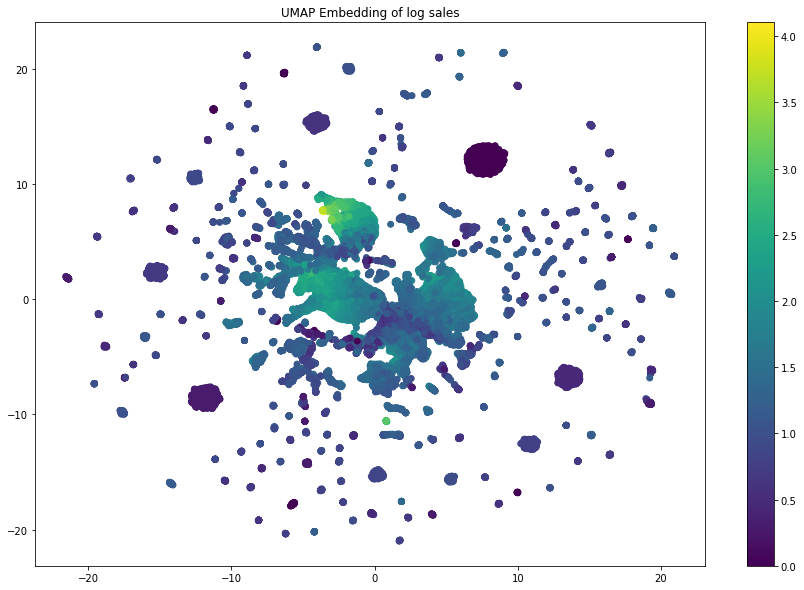

In [89]:
f, ax = plt.subplots(figsize=(15,10))
sc = ax.scatter(sales_df[0], sales_df[1], c=sales_df['sales_log'], cmap='viridis')
plt.colorbar(sc)
ax.set_title('UMAP Embedding of log sales')
plt.show()

# Clustering and cluster analysis

In [90]:
run_cont = ['sales']#, 'selling_price', 'avg_discount', 'stock_open']
run_cats = ['sku_department', 'sku_subdepartment', 'sku_category', 'sku_subcategory', 'sku_label']

In [91]:
som_clus = pd.read_csv('../data/output/som_clusters.csv')
som_clus.columns = ['sku_key', 'cluster']

analyze_som = AnalyzeClusters()
df_dict = analyze_som.make_dataset(product_sales, som_clus)

Cluster sizes:


In [92]:
for i, j in df_dict.items():
    print(i, len(j['sku_key'].unique()))

cluster_3 15771
cluster_0 21523
cluster_2 6921
cluster_1 627


Clusters on embedding

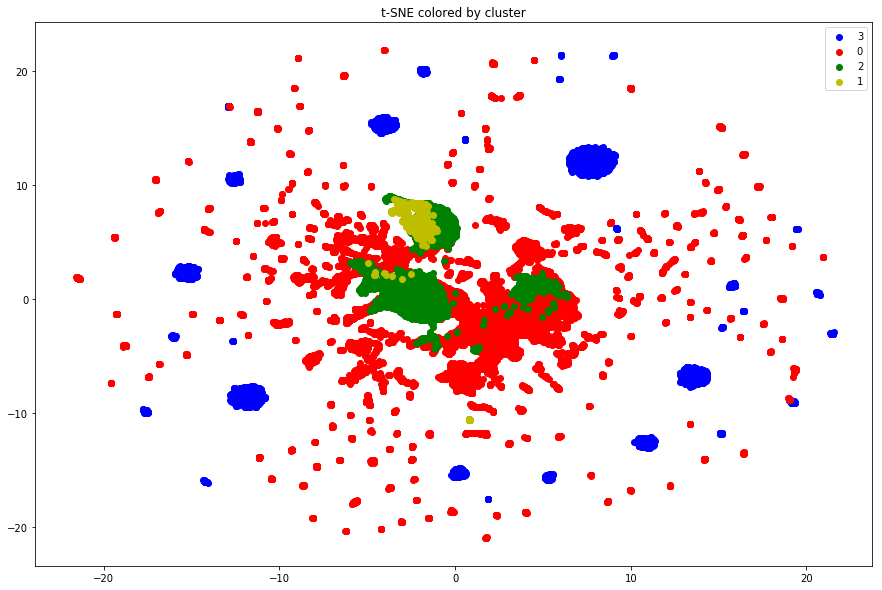

In [93]:
som_tsne = plot_df.merge(som_clus, left_on='id', right_on='sku_key')

plot_by_factor(som_tsne, 'cluster', colors, True)

Have a look at the time series for each of the clusters

In [34]:
#analyze_som.plot_all_timeseries(df_dict)

Have a look at the mean time series for each of the clusters

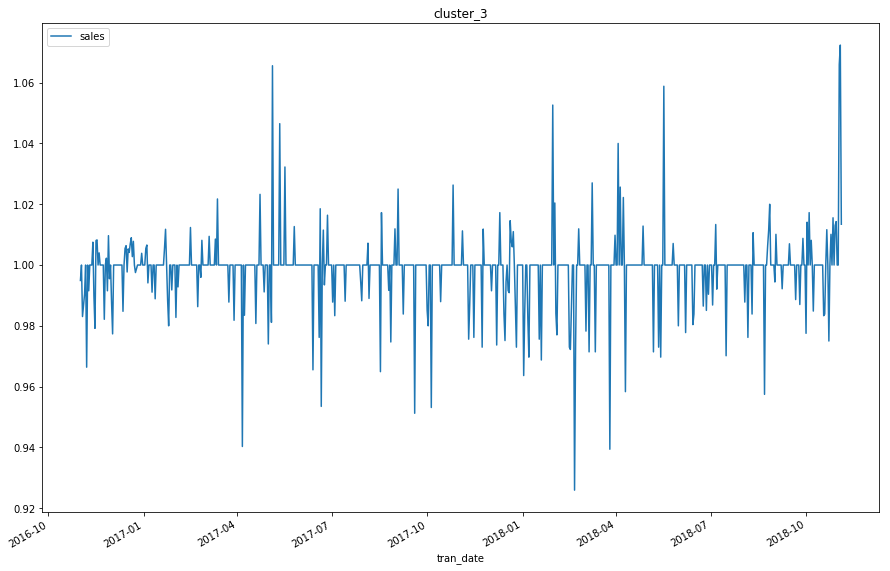

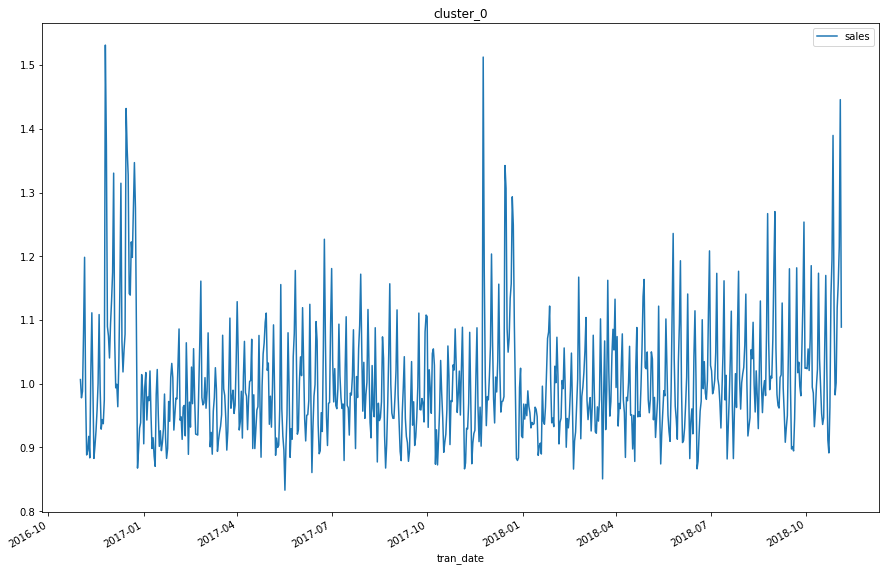

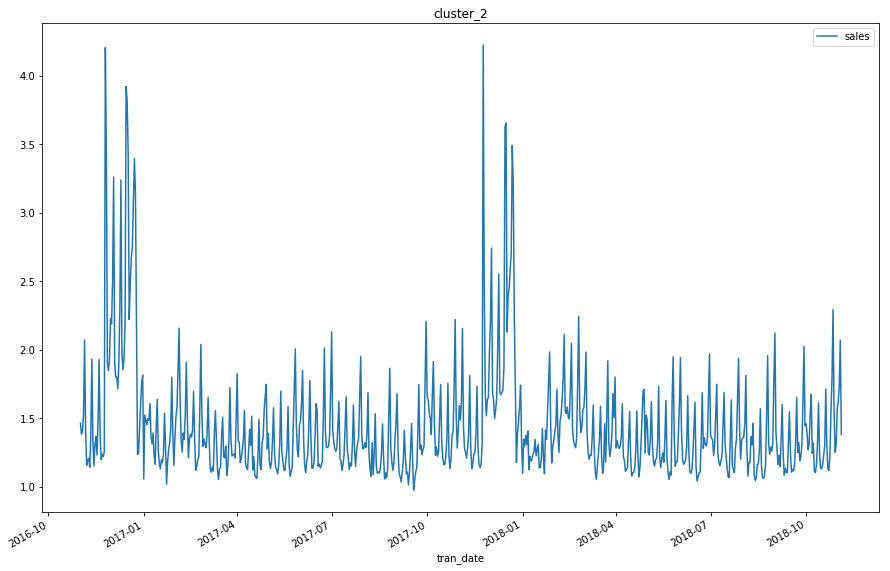

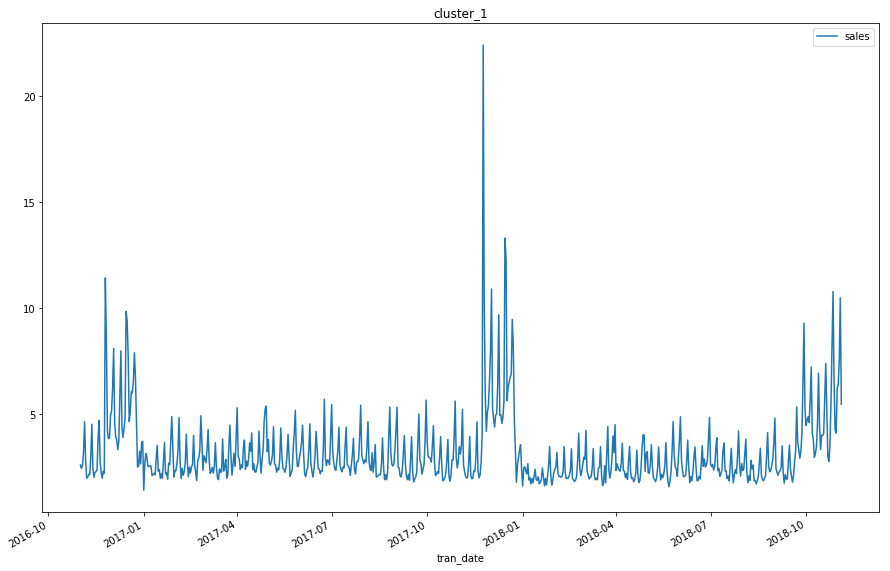

In [23]:
analyze_som.plot_mean_timeseries(df_dict)

Have a look at the median time series for each of the clusters

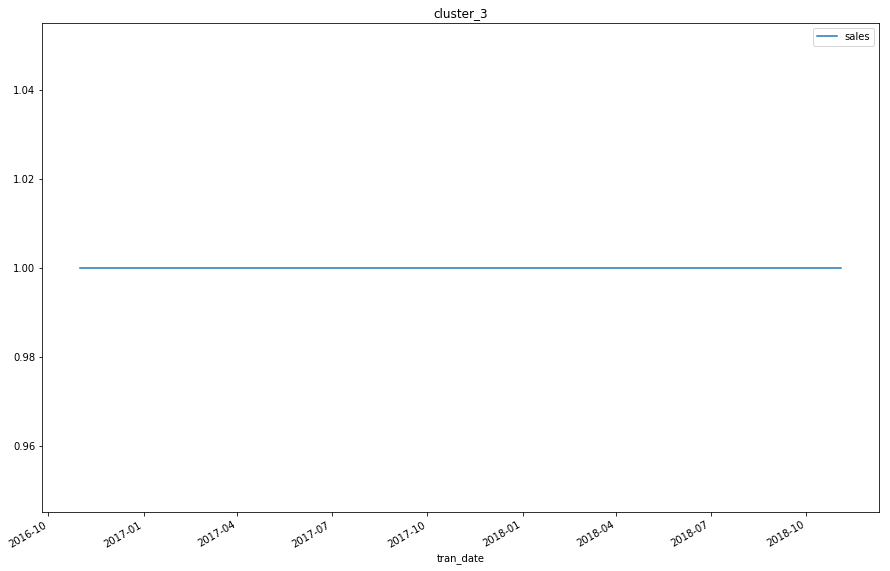

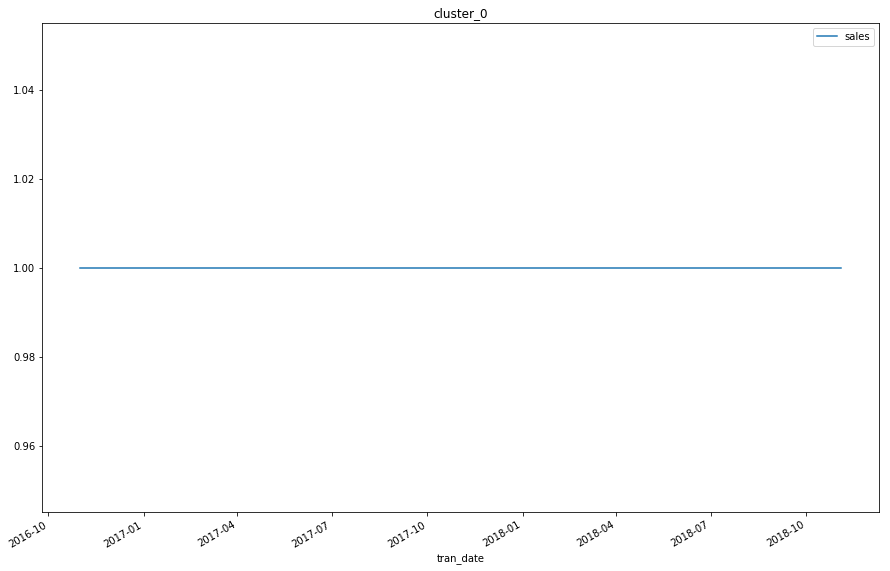

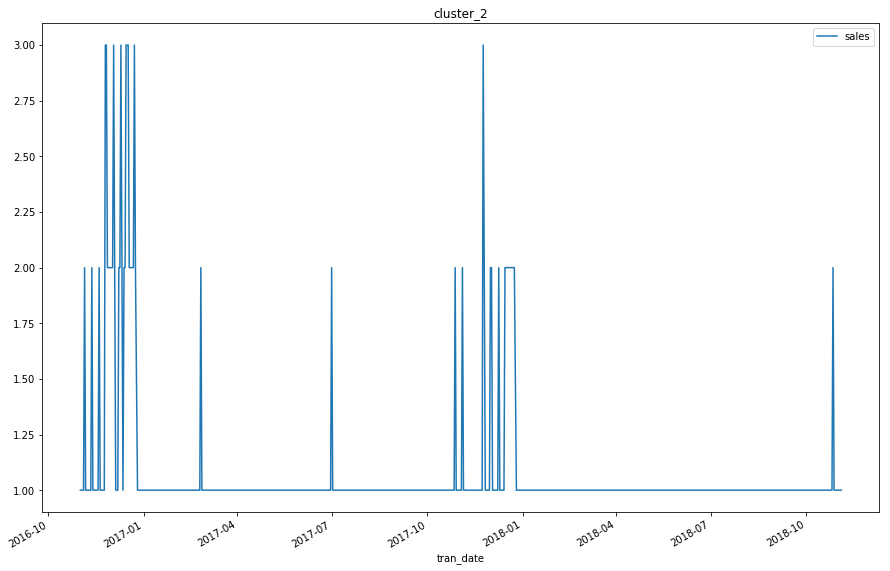

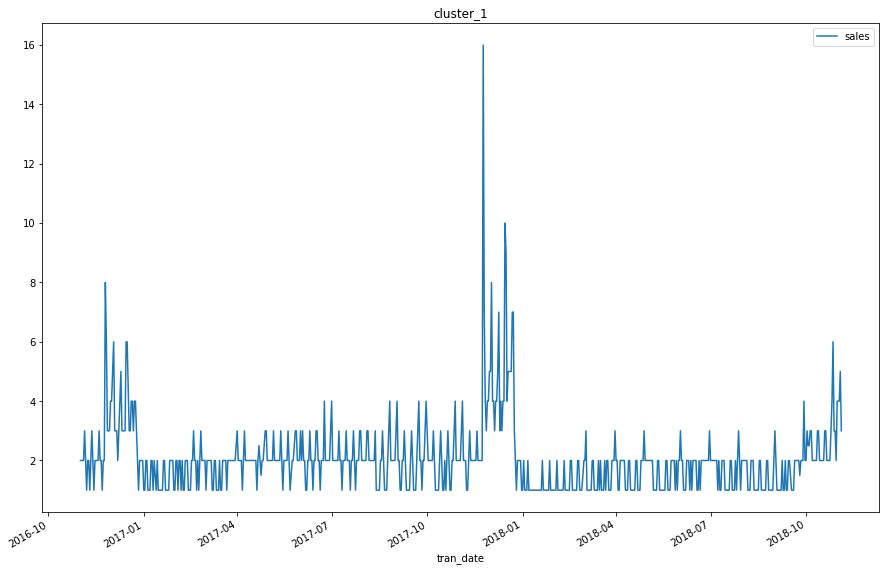

In [24]:
analyze_som.plot_median_timeseries(df_dict)

Have a look at the smoothed mean for each of the clusters

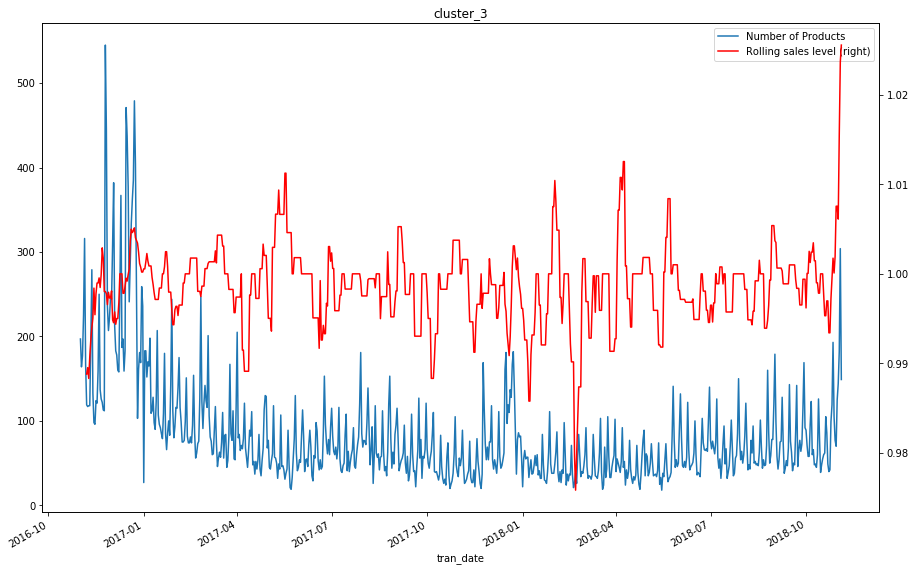

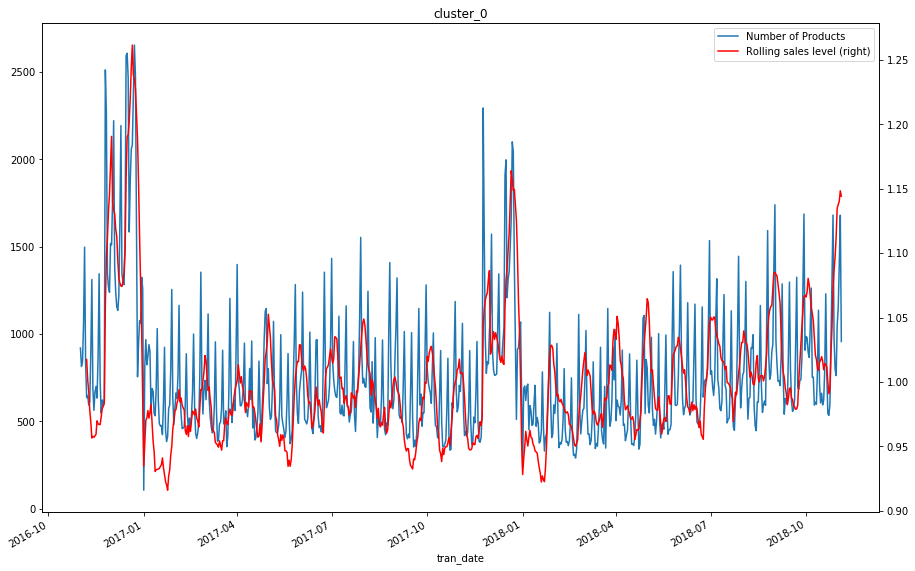

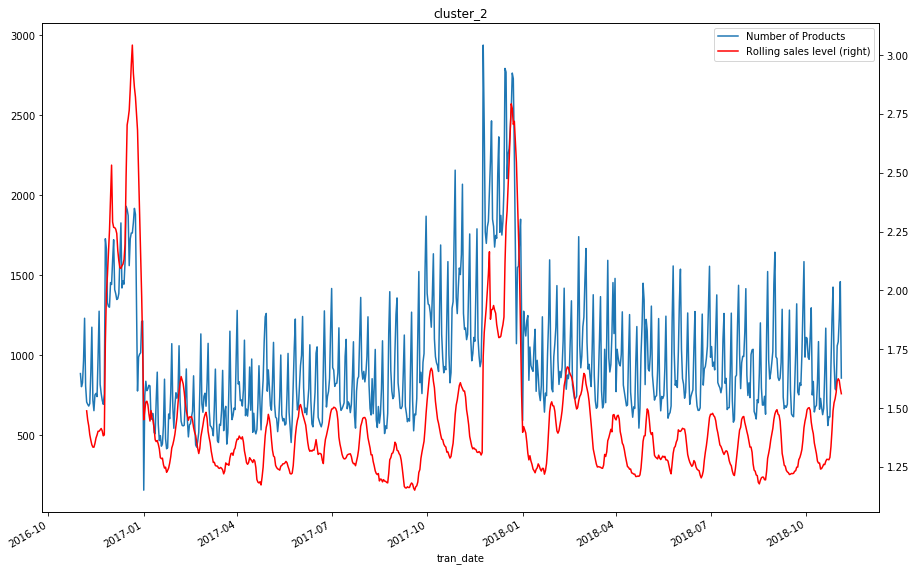

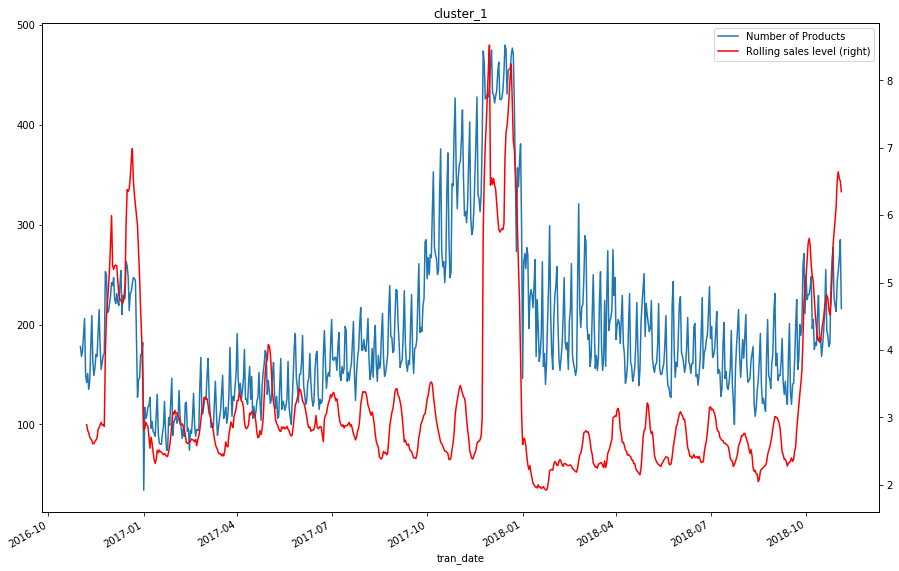

In [25]:
analyze_som.plot_rolling_mean_timeseries(df_dict, 'sales', plot_second=True,  period=7)

In [27]:
#We do not yet have the stock levels
#analyze_som.plot_rolling_mean_timeseries(df_dict, 'stock_open', plot_second=True,  period=7)

In [28]:
#We do not yet have the stock levels
#analyze_som.plot_double_rolling_mean(df_dict, ['stock_open', 'sales'], plot_second=True,  period=7)

Have a look at the amount of time series which start within the specified period or which started priod to the start of the period

cluster_3, there are 15771 skus and 60394 sales.


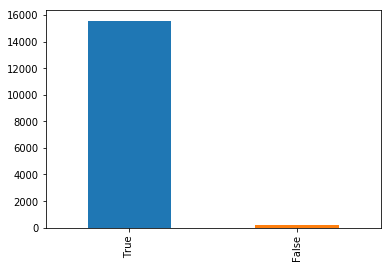

cluster_0, there are 21523 skus and 579412 sales.


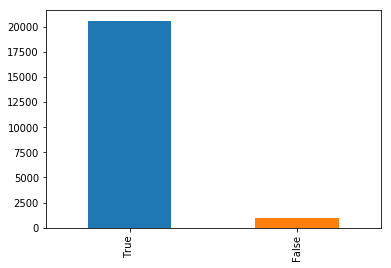

cluster_2, there are 6921 skus and 1138992 sales.


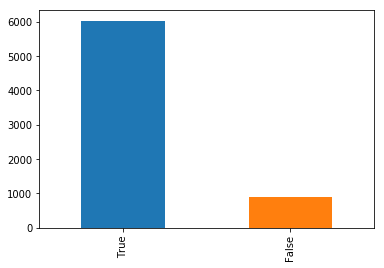

cluster_1, there are 627 skus and 508575 sales.


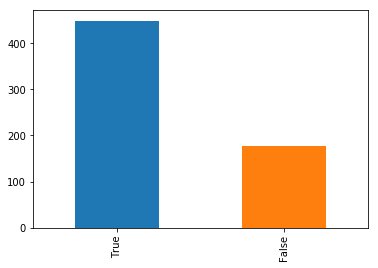

In [29]:
for i, j in df_dict.items():
    print('{}, there are {} skus and {} sales.'.format(i, len(j['sku_key'].unique()), sum(j['sales'])))
    pivot_t = pd.pivot_table(j, index='sku_key', columns='tran_date', values='sales')
    pivot_t['nan'] = pivot_t.iloc[:,0].apply(np.isnan)
    pivot_t['nan'].value_counts().plot(kind='bar')
    plt.show()

Have a look at the distribution of the continuous variables for each cluster

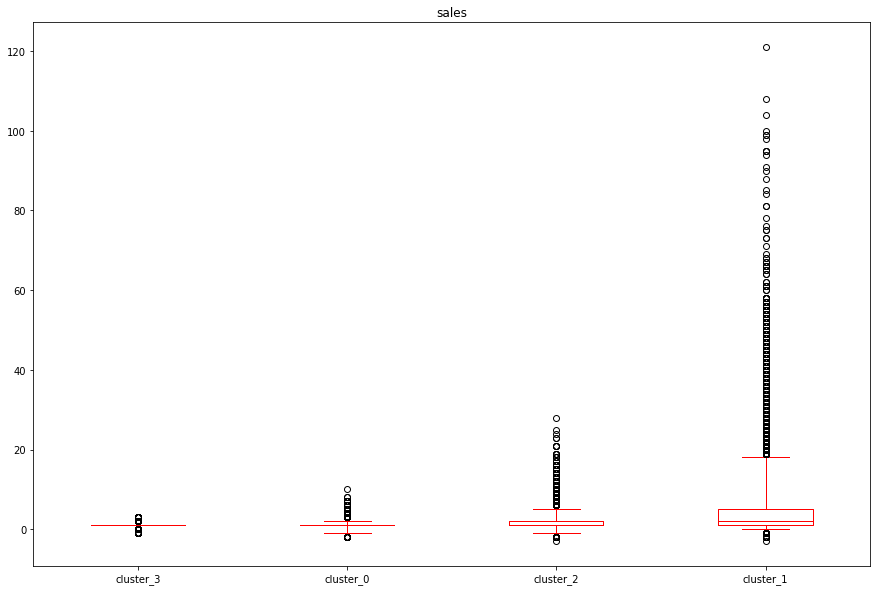

In [32]:
analyze_som.plot_cluster_continuous_box(df_dict, run_cont, True)
#OPTIONAL BELOW
#analyze_som.plot_cluster_continuous(df_dict, run_cont, colors, True)
#analyze_som.plot_cluster_continuous_violin(df_dict, run_cont, True)

Have a look at the number of returns per cluster and relative percentage

cluster_3 had 60422 sale events
cluster_0 had 555011 sale events
cluster_2 had 717649 sale events
cluster_1 had 141812 sale events


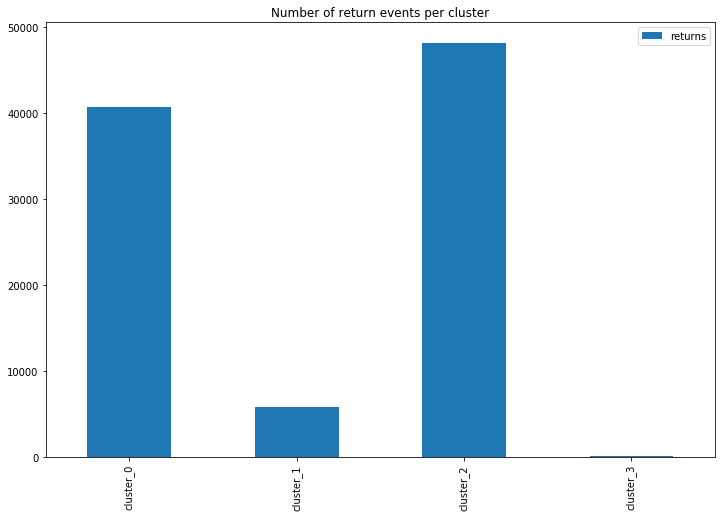

In [35]:
listy = {}
for a, i in df_dict.items():
    print('{} had {} sale events'.format(a, len(i['sales'])))
    x = i[i['sales'] <= 0]['sales'].count()
    listy[a] = x
f, ax = plt.subplots(figsize=(12,8))
pd.DataFrame(listy, index=['returns']).T.plot(kind='bar', ax=ax)
plt.title('Number of return events per cluster')
plt.show()

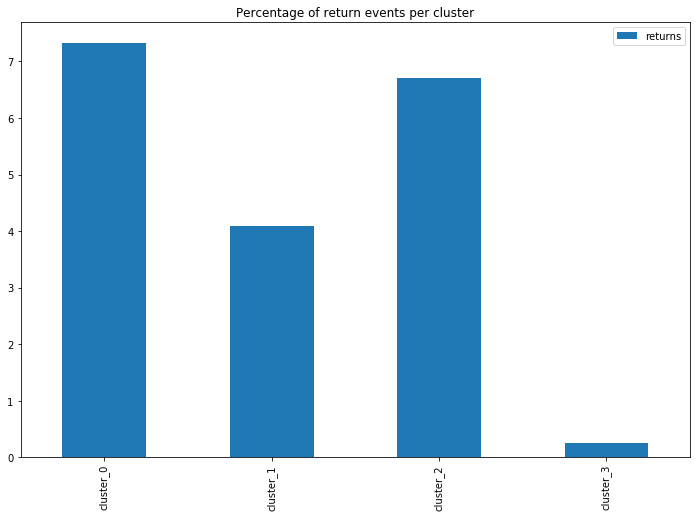

In [36]:
listy = {}
for a, i in df_dict.items():
    x = i[i['sales'] <= 0]['sales'].count()/i['sales'].count()*100
    listy[a] = x
    
f, ax = plt.subplots(figsize=(12,8))
pd.DataFrame(listy, index=['returns']).T.plot(kind='bar', ax=ax)
plt.title('Percentage of return events per cluster')
plt.show()

Look at the stock shortages

In [37]:
#Don't have stock yet
#listy = {}
#for a, i in df_dict.items():
#    x = i[i['stock_open'] < 0]['stock_open'].count()
#    listy[a] = x
#    
#f, ax = plt.subplots(figsize=(12,8))
#pd.DataFrame(listy, index=['returns']).T.plot(kind='bar', ax=ax)
#plt.title('Percentage of shortages events per cluster')
#plt.show()

In [38]:
#Don't have stock yet
#listy = {}
#for a, i in df_dict.items():
#    x = i[i['stock_open'] < 0]['stock_open'].count()/i['stock_open'].count()*100
#    listy[a] = x
#    
#f, ax = plt.subplots(figsize=(12,8))
#pd.DataFrame(listy, index=['returns']).T.plot(kind='bar', ax=ax)
#plt.title('Percentage of shortages events per cluster')
#plt.show()

Categorical variables per cluster

Some messy inferential stats:

In [39]:
analyze_som.test_continuous_feat(df_dict, run_cont)


 
 sales
                sum_sq        df             F  PR(>F)
cluster   3.476508e+05       3.0  14353.564362     0.0
Residual  1.951237e+06  241684.0           NaN     NaN 

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower   upper  reject
---------------------------------------------------
cluster_0 cluster_1  2.8861   2.8441  2.9281  True 
cluster_0 cluster_2  0.503    0.461   0.545   True 
cluster_0 cluster_3 -0.0249  -0.0669  0.0171 False 
cluster_1 cluster_2 -2.3831  -2.4251 -2.3411  True 
cluster_1 cluster_3  -2.911   -2.953  -2.869  True 
cluster_2 cluster_3 -0.5279  -0.5699 -0.4859  True 
---------------------------------------------------


Now moving to cumulative sales per cluster

In [40]:
som_sales_df = sales_df.merge(som_clus, on='sku_key')
som_sales_df.head()

,sku_key,sales,0,1,sales_log,cluster
0,247497,9,14.386982,6.334747,0.954243,3
1,247498,3,-3.355404,-12.232363,0.477121,3
2,247501,59,2.887570,-2.855832,1.770852,0
3,247505,102,-6.274271,-1.056789,2.008600,2
4,247506,2,6.648865,-14.924373,0.301030,3


cluster 3
15771


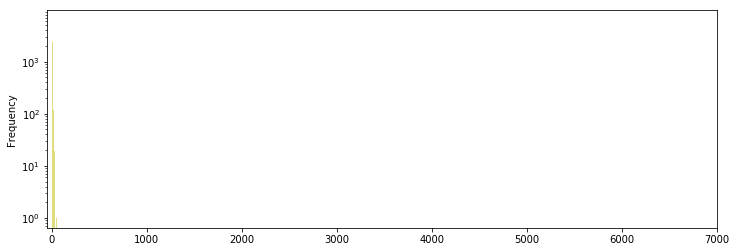

cluster 0
21523


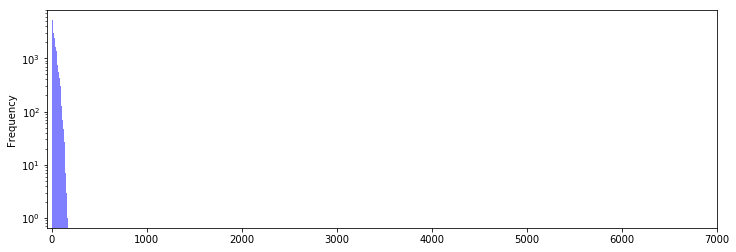

cluster 2
6921


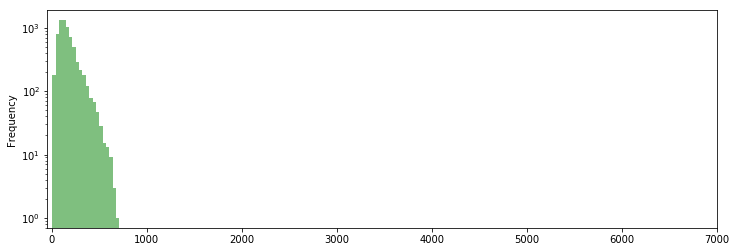

cluster 1
627


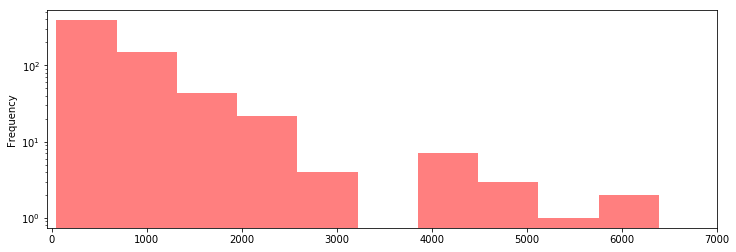

In [45]:
for i in som_sales_df['cluster'].unique():
    print('cluster {}'.format(i))
    print(len(som_sales_df[som_sales_df['cluster'] == i]['sales']))
    f, ax = plt.subplots(figsize=(12,4))
    som_sales_df[som_sales_df['cluster'] == i]['sales'].T.plot(kind='hist', color=colors[i], alpha=0.5, bins=20, ax=ax, logy=True)
    ax.set_xlim(-50, 7000)
    plt.show()

In [46]:
for a, i in enumerate(som_sales_df['cluster'].unique()):
    if a == 0:
        int_df = pd.DataFrame(som_sales_df[som_sales_df['cluster'] == i]['sales'])
        int_df.columns = [i]
    else:
        temp = pd.DataFrame(som_sales_df[som_sales_df['cluster'] == i]['sales'])
        temp.columns = [i]
        int_df = int_df.join(temp, how='outer')


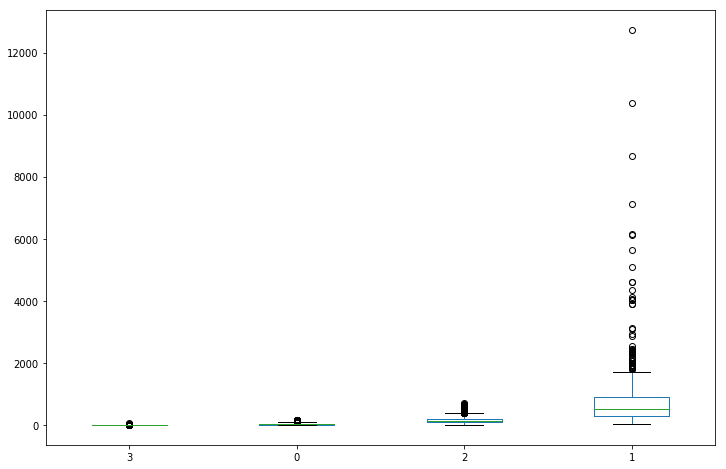

In [47]:
f, ax = plt.subplots(figsize=(12,8))
int_df.plot(kind='box', ax=ax)


In [48]:
int_df_unpiv = int_df.melt().dropna()
int_df_unpiv.columns = ['cluster', 'value']
int_df_unpiv.head()

,cluster,value
0,3,9.0
1,3,3.0
4,3,2.0
10,3,3.0
11,3,1.0


In [49]:
mod = ols('value ~ cluster',
                data=int_df_unpiv).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)


                sum_sq       df          F   PR(>F)
cluster   3.965588e+05      1.0  13.650323  0.00022
Residual  1.302658e+09  44840.0        NaN      NaN


In [50]:
print(pairwise_tukeyhsd(int_df_unpiv['value'], int_df_unpiv['cluster']))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff   lower     upper   reject
-------------------------------------------------
  0      1    784.2038  770.2667  798.1409  True 
  0      2    137.6498  132.8961  142.4035  True 
  0      3    -23.0912  -26.697   -19.4853  True 
  1      2    -646.554 -660.9013 -632.2067  True 
  1      3    -807.295 -821.3039 -793.2861  True 
  2      3    -160.741 -165.7012 -155.7809  True 
-------------------------------------------------


In [80]:
map_dict = {}
for a, i in df_dict.items():
    print(a, i['sales'].mean())
    map_dict[int(a[-1])] = str(round(i['sales'].mean(), 4)) + ' sales per day'

cluster_3 0.9995365926318228
cluster_0 1.0439648943894806
cluster_2 1.587115706982104
cluster_1 3.5862620934758693


In [81]:
map_dict

{3: '0.9995 sales per day',
 0: '1.044 sales per day',
 2: '1.5871 sales per day',
 1: '3.5863 sales per day'}

In [82]:
som_clus['description'] = som_clus['cluster'].map(map_dict)

In [86]:
som_clus.to_csv('footgear_clusters.csv', index=False)

In [84]:
som_clus.head()

,sku_key,cluster,description
0,247497,3,0.9995 sales per day
1,247498,3,0.9995 sales per day
2,247501,0,1.044 sales per day
3,247505,2,1.5871 sales per day
4,247506,3,0.9995 sales per day
